# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 29.11.2023

Мягий дедлайн: 23:59 12.12.2023

Жестокий дедлайн: 23:59 14.12.2023

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/56884/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

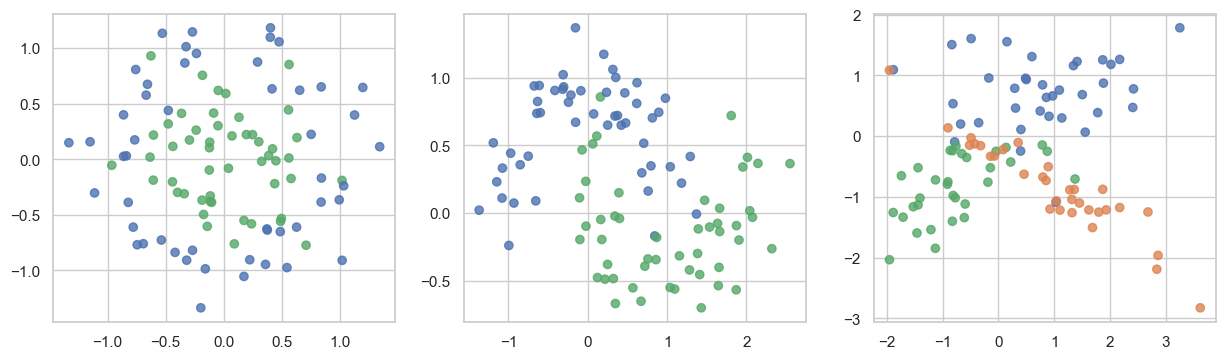

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y, ax=None, title="Classifier Surface"):
    if not ax:
        fig, ax = plt.subplots(1, 1)
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    ax.set_title(title)

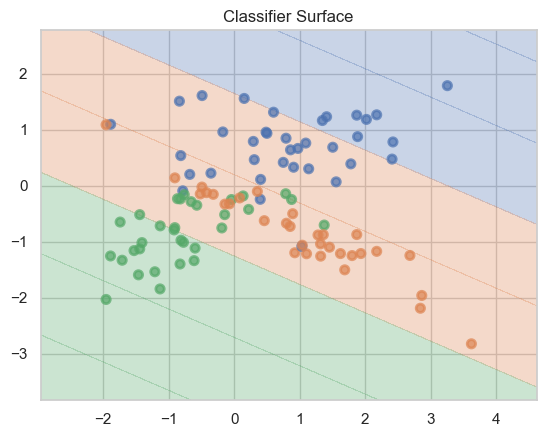

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)
plt.show()

Dataset: circles
Train score: 1.00
Train score: 0.76

Dataset: moons
Train score: 1.00
Train score: 0.92

Dataset: standard
Train score: 1.00
Train score: 0.72



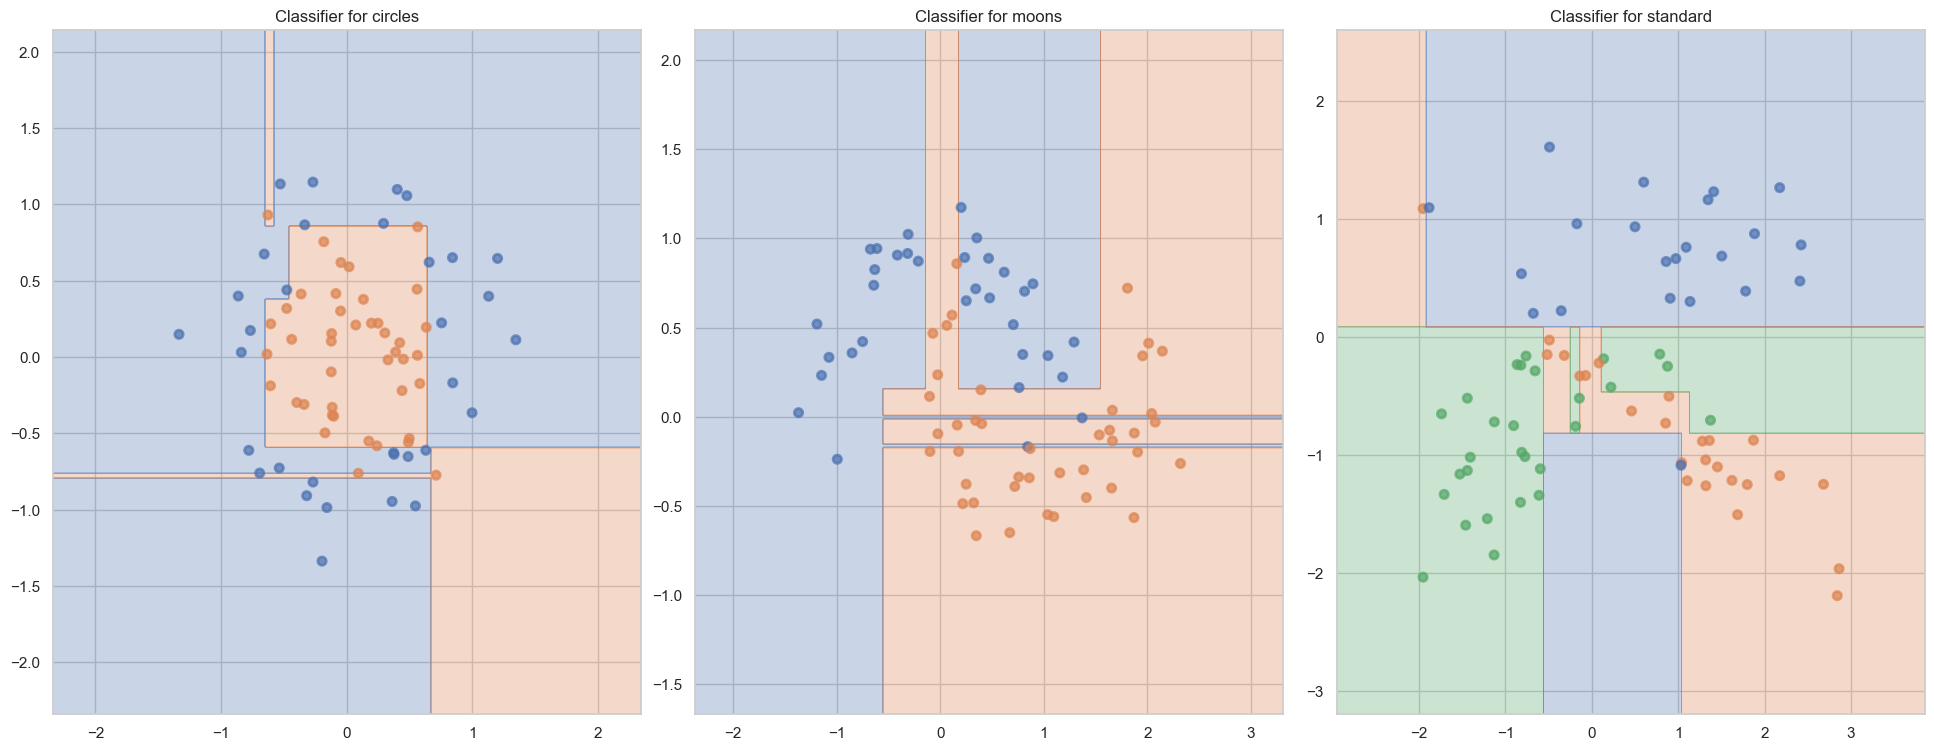

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

datasets_splitted = []
dataset_names = ["circles", "moons", "standard"]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

def accuracy(X, y_gt, clf):
    y_pred = clf.predict(X)
    return np.mean(y_pred == y_gt)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

for (X, y), name, ax in zip(datasets, dataset_names, axes):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)
    datasets_splitted.append([X_train, X_test, y_train, y_test])
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    plot_surface(clf, X_train, y_train, ax, title=f"Classifier for {name}")
    print(f"Dataset: {name}")
    print(f"Train score: {accuracy(X_train, y_train, clf):.2f}")
    print(f"Train score: {accuracy(X_test, y_test, clf):.2f}")
    print()

plt.show()


__Ответ:__ Переобучение максимально жесткое - у нас маленький датасет и, как видно, даже "свои среди чужих" выделились отдельной зоной, чего бы совсем не хотелось допускать

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

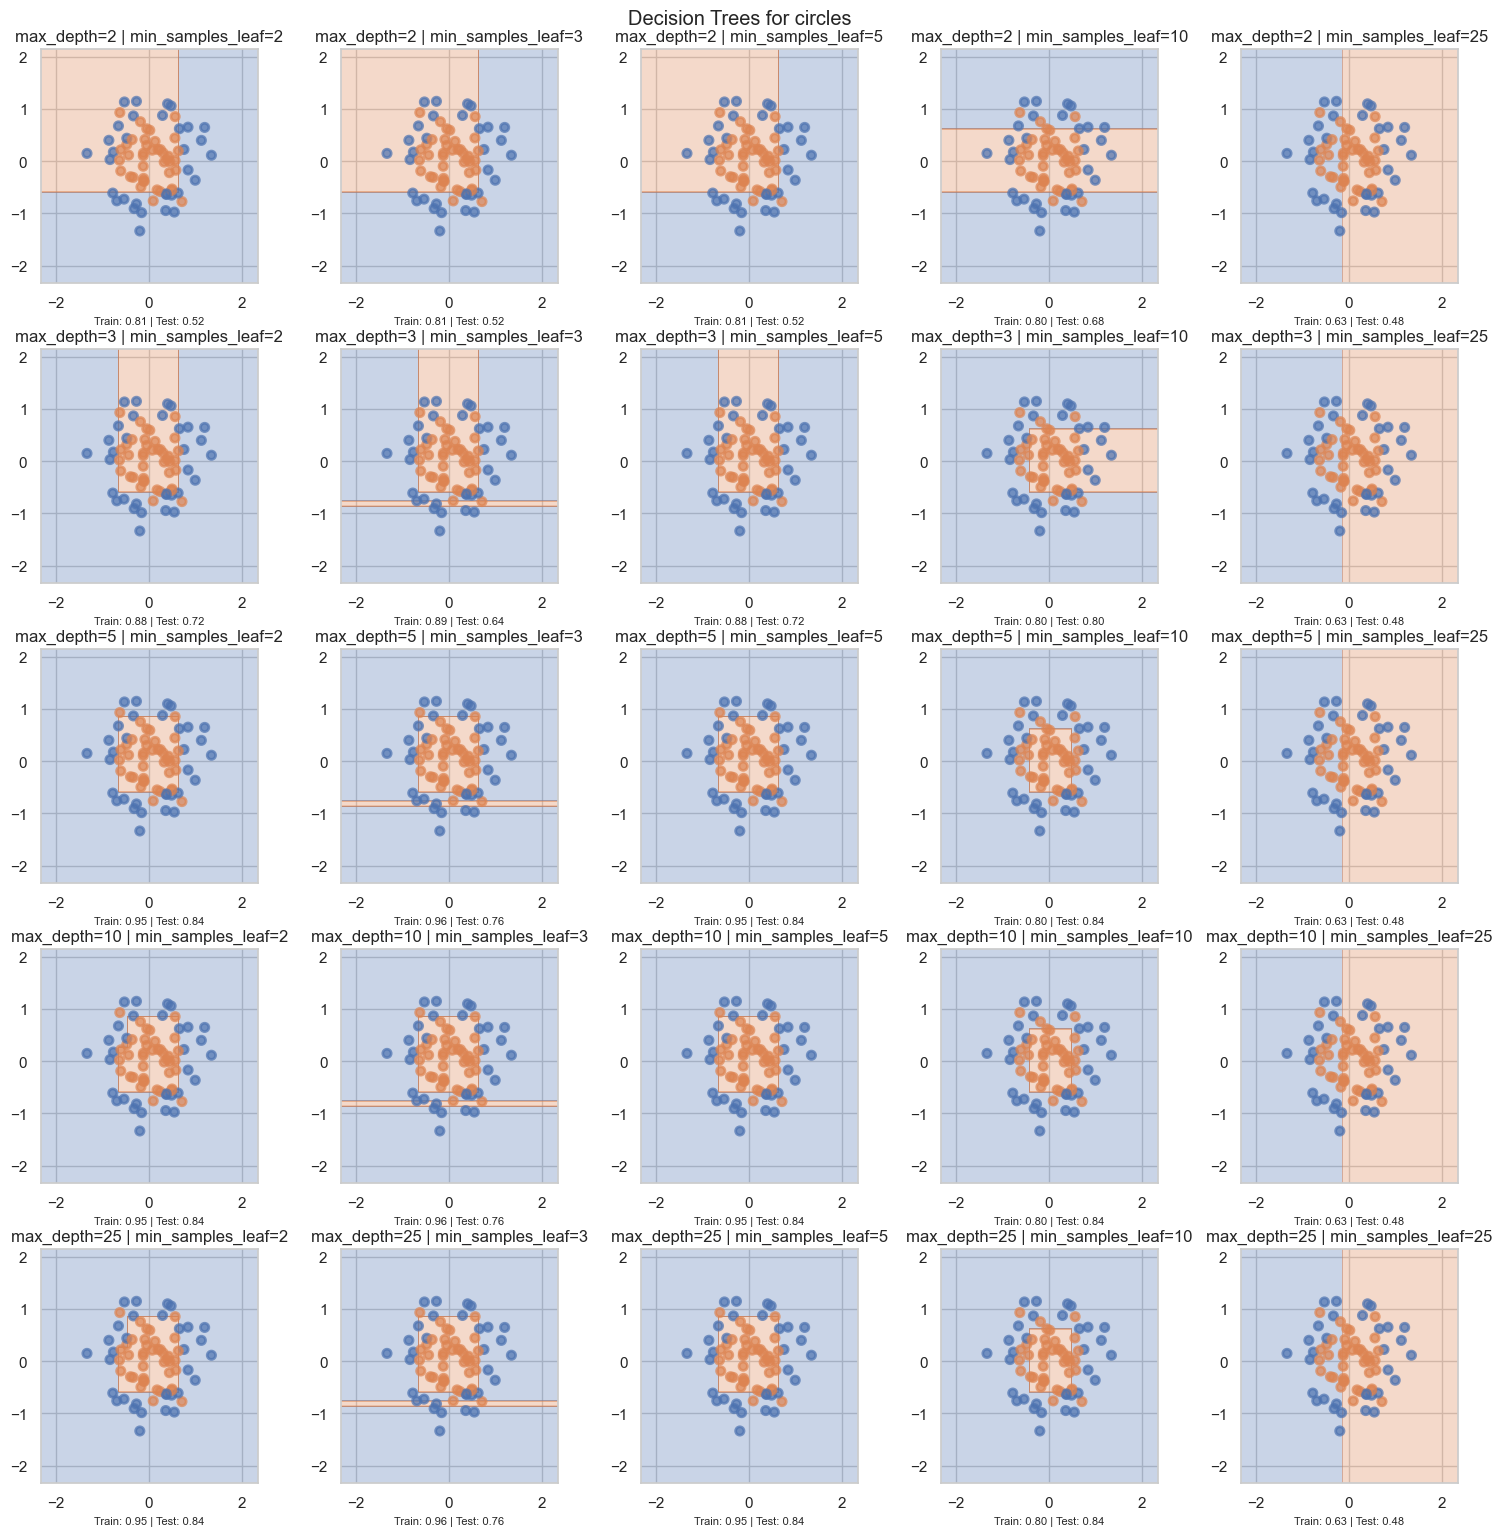

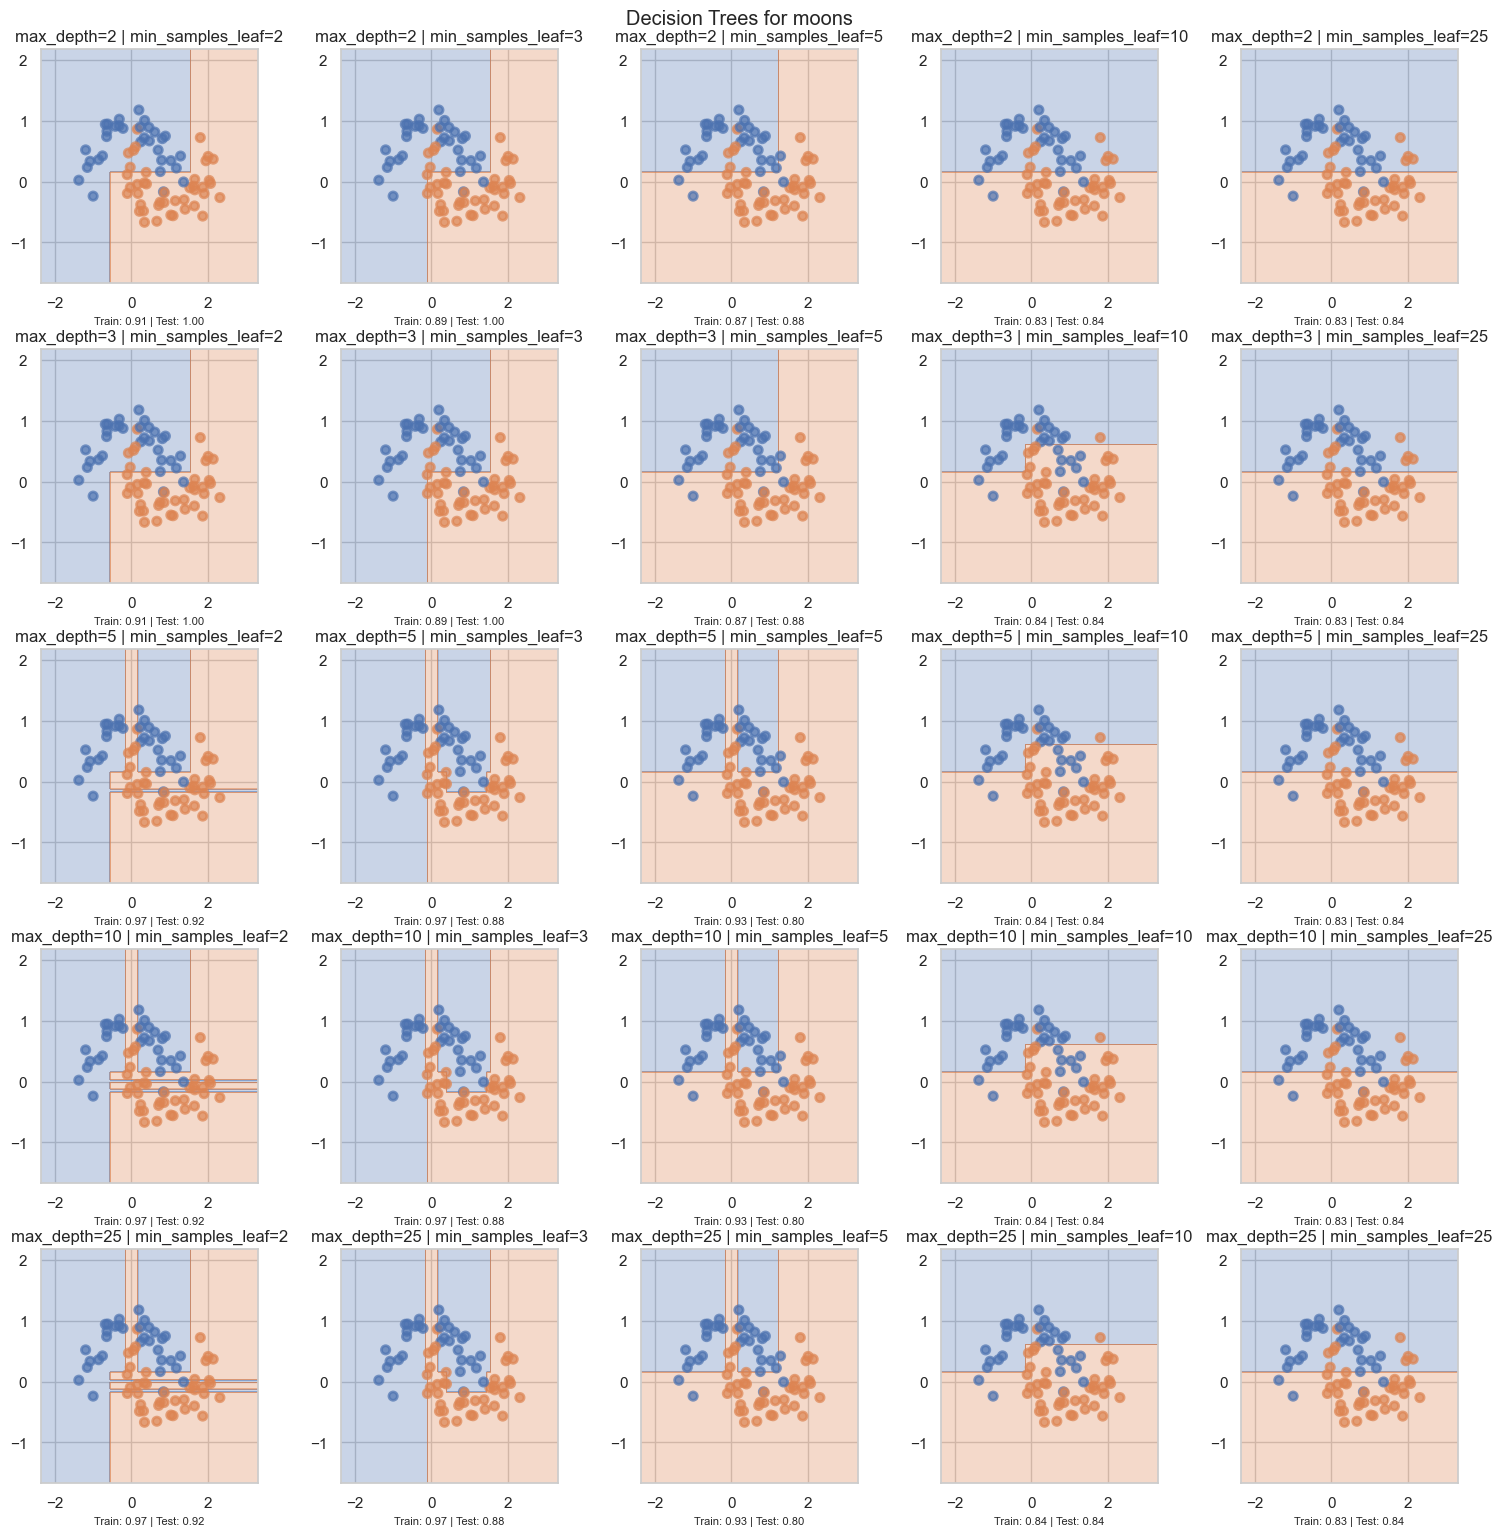

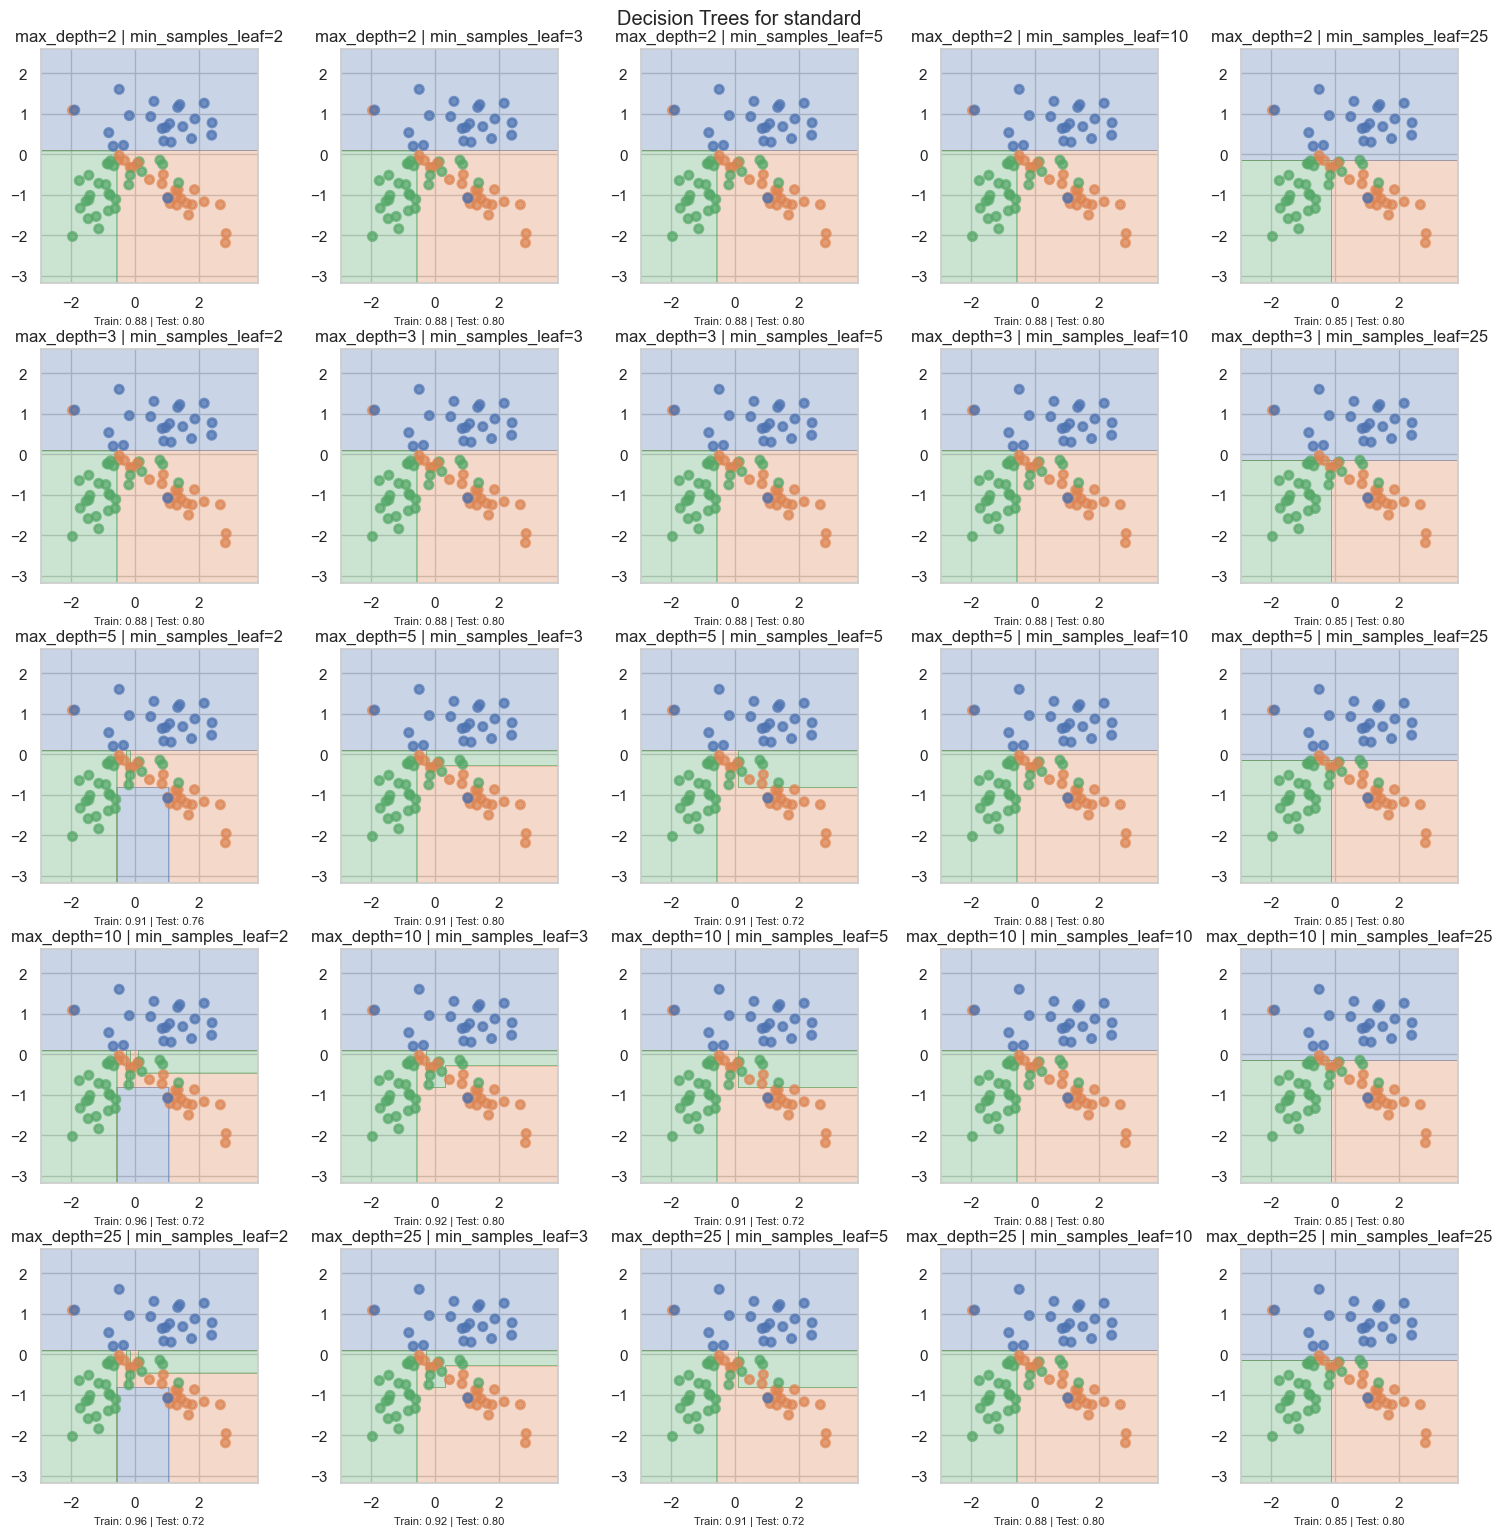

In [8]:
max_depth_arr = [2, 3, 5, 10, 25]
min_samples_leaf_arr = [2, 3, 5, 10, 25]

for (X_train, X_test, y_train, y_test), name in zip(datasets_splitted, dataset_names):

    fig, ax = plt.subplots(len(max_depth_arr), len(min_samples_leaf_arr), figsize=(16, 16))
    plt.tight_layout(h_pad=2, w_pad=2, pad=4)
    plt.suptitle(f"Decision Trees for {name}")

    for i, max_depth in enumerate(max_depth_arr):
        for j, min_samples_leaf in enumerate(min_samples_leaf_arr):
            
            clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=42)
            clf.fit(X_train, y_train)

            plot_surface(clf, X_train, y_train, ax[i][j], title=f"max_depth={max_depth} | min_samples_leaf={min_samples_leaf}")
            ax[i][j].set_xlabel(f"Train: {accuracy(X_train, y_train, clf):.2f} | Test: {accuracy(X_test, y_test, clf):.2f}", fontsize=8)
    
    plt.show()

__Ответ:__ При увеличении глубины дерева оно начинает переобучаться, потому что мы позволяем ему дробить плоскость на мелкие зоны. Увеличение минимального числа объектов в листе наоборот сглаживает деление, не создавая листья с маленьким количеством объектов выборки - мы не переобучаемся. Вполне логично, что оптимум обобщающей способности будет где-то посередине. Но при этом чем сложнее выборка - тем все же больше модельке нужно глубины, чтобы понять закономерность в данных - сравним это (в случае примерно равных результатов возьмем самую простую модель)

max_depth | min_samples_leaf\
Circles: 5 | 10\
Moons: 2 | 5\
Standard: 2 | 25

В целом гипотеза подверждается (что сложнее: круг или инь-янь - решать читателю). При этом видно, что стандартная выборка переобучается быстрее и сильнее всего - в ней больше всего пересечений классов. При этом на этой выборке модель меньше других "недообучается" - инь-янь и круг на очень простых деревьях не находят нужные зоны и плоскости получаются примитивными

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

In [9]:
from hw5code import find_best_split

%load_ext autoreload
%autoreload 2

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [10]:
students = pd.read_csv("students.csv")
target = students.columns[-1]
features = students.columns[:-1]
students.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


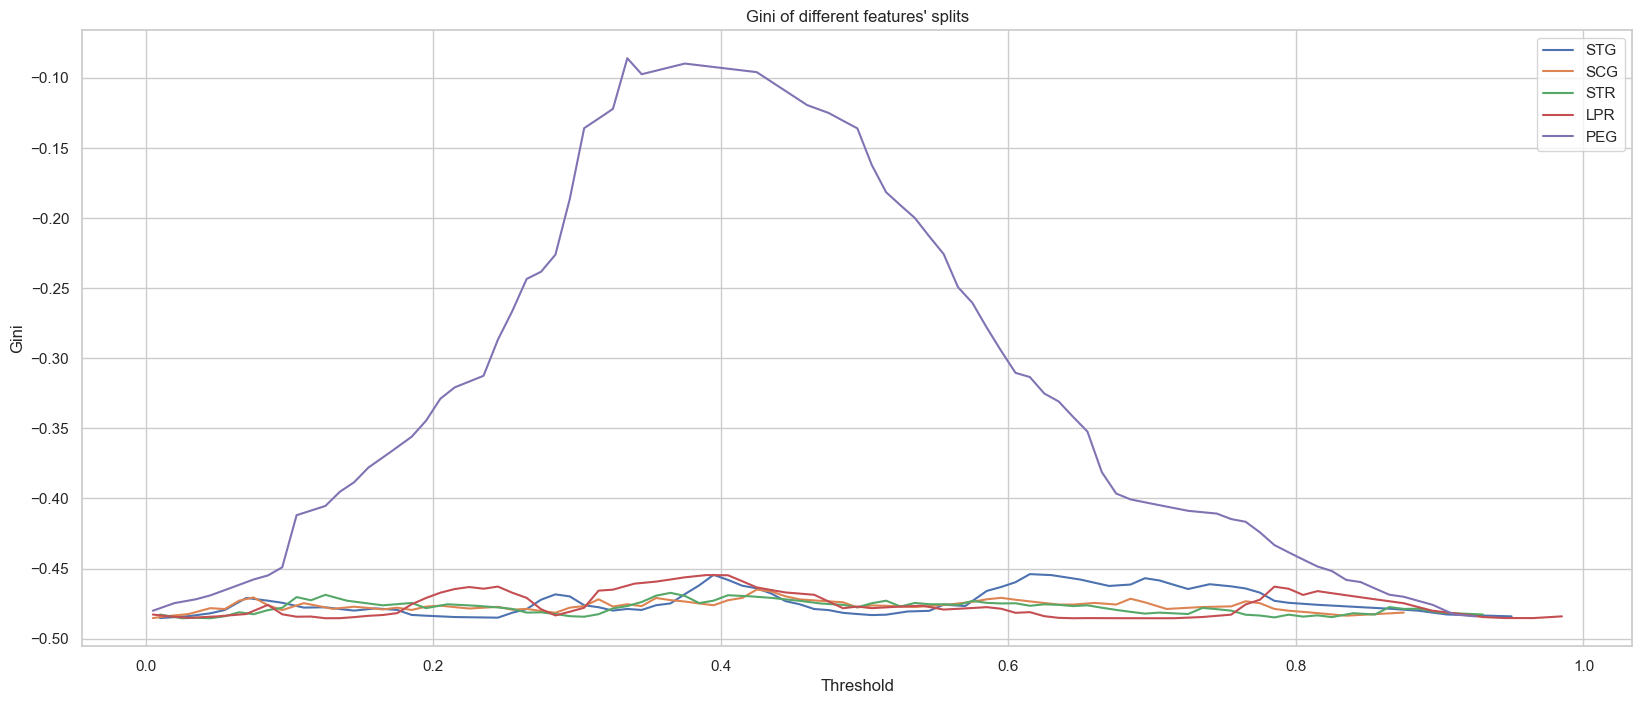

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

for feature in features:
    thresholds, ginis, threshold_best, gini_best = find_best_split(np.array(students[feature]), np.array(students[target]))
    ax.plot(thresholds, ginis, label=feature)

ax.set_title("Gini of different features\' splits")
ax.legend(loc='best')
ax.set_ylabel("Gini")
ax.set_xlabel("Threshold")

plt.show()

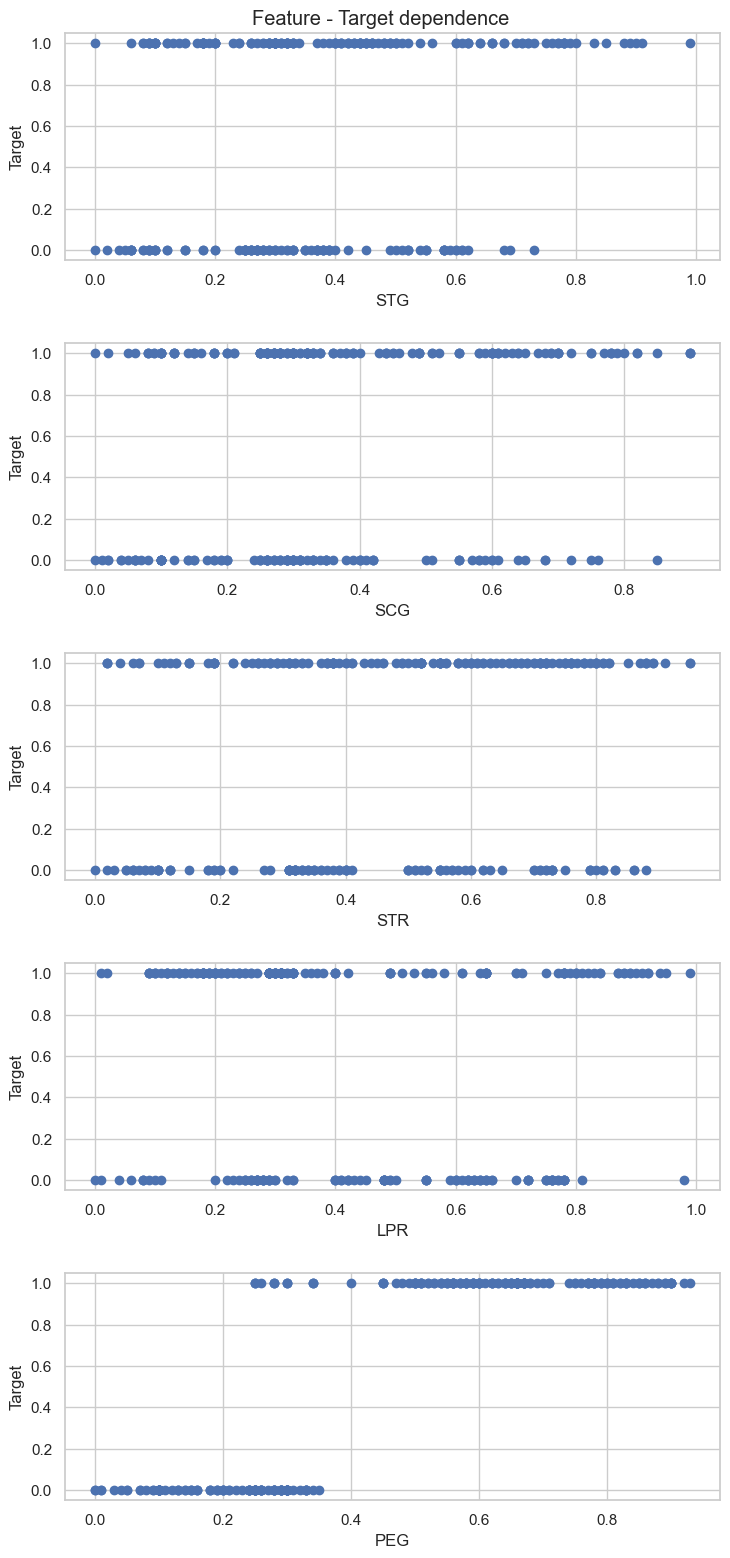

In [12]:
fig, ax = plt.subplots(5, 1, figsize=(8, 16))
plt.tight_layout(pad=3)

for i, feature in enumerate(features):
    ax[i].scatter(students[feature], students[target])
    ax[i].set_ylabel("Target")
    ax[i].set_xlabel(f"{feature}")

plt.suptitle("Feature - Target dependence")
plt.show()

Честно, scatter - это худшее, что можно изобразить в данной ситуации. Вообще говоря, логично посмотреть на это:

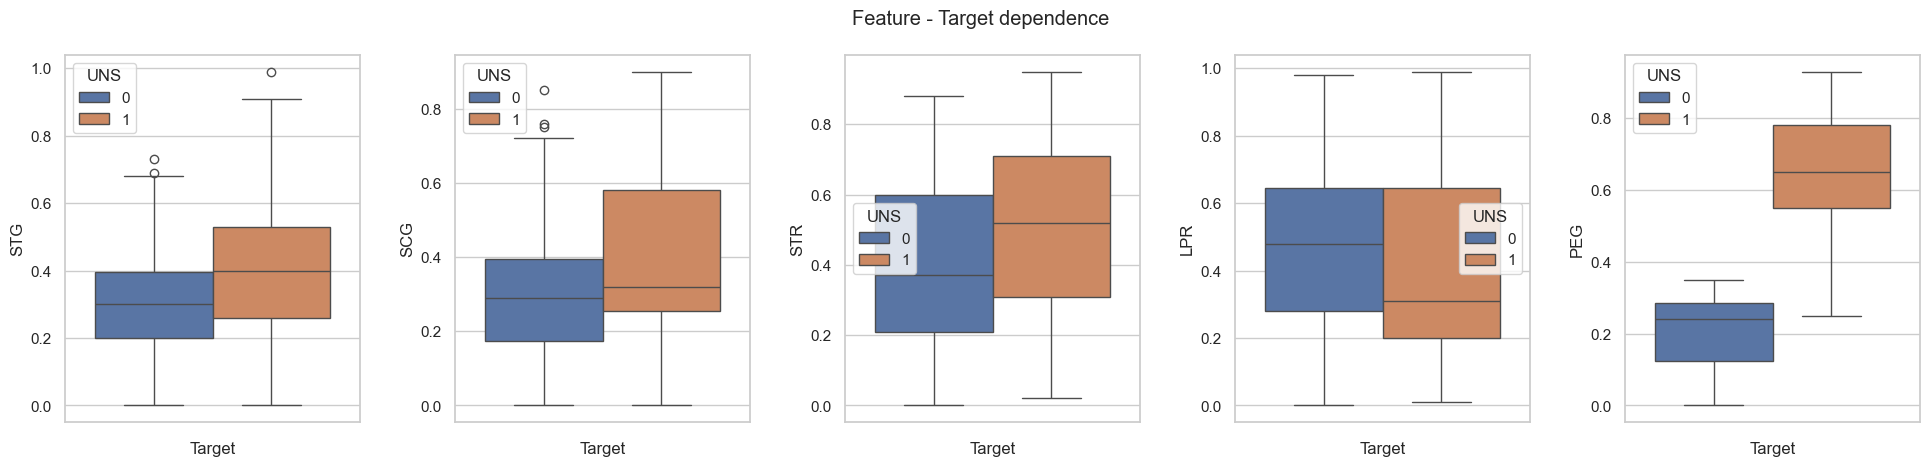

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
plt.tight_layout(pad=3)

for i, feature in enumerate(features):
    sns.boxplot(y=students[feature], hue=students[target], ax=ax[i])
    ax[i].set_ylabel(f"{feature}")
    ax[i].set_xlabel(f"Target")

plt.suptitle("Feature - Target dependence")
plt.show()

Совсем другое дело

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Судя по кривым, делить нужно по PEG - тогда impurity будет наименьшей. Распределения фичей это подтверждает - у нас процент пересечения (разный таргет, но одинаковое значение фичи) - меньше 20%, если судить по квантилям. PEG настолько хорошо разделяет выборку, что здесь даже scatter было достаточно. 

Кривая выпуклая и имеет один экстремум - если чуть сгладить, то она будет идеально похожа на нормальное распределение. По остальным фичам прямые близки к константе, но при этом сильно шумят. Идеально выпуклый вид по сути означает, что можно сделать тернарный => бинарный поиск, то есть найти то значение признака, меньше которого все объекты относятся к 0-му классу, а больше - к 1-му. В реальности данные почти всегда линейно неразделимы в силу большого числа факторов и тд, поэтому мы находим лучшую такую точку, разбивающую выборку.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [17]:
from hw5code_volodin import DecisionTree as MyDecisionTree
from sklearn.preprocessing import LabelEncoder

mushrooms = pd.read_csv("agaricus-lepiota.data", header=None)
mushrooms.head()


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [18]:
mushrooms = mushrooms.apply(LabelEncoder().fit_transform)
mushrooms.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [20]:
X, y = np.array(mushrooms)[:, 1:], np.array(mushrooms)[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.5)

clf = MyDecisionTree(["categorical"] * 22)
clf.fit(X_train, y_train)

print(f"Train score: {accuracy(X_train, y_train, clf):.2f}")
print(f"Test score: {accuracy(X_test, y_test, clf):.2f}")

Train score: 1.00
Test score: 1.00


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [18]:
tic_tac_toe = pd.read_csv("tic-tac-toe-endgame.csv")
tic_tac_toe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


Такая странная задача для машинного обучения...

In [19]:
tic_tac_toe = tic_tac_toe.apply(LabelEncoder().fit_transform)
tic_tac_toe.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,2,2,2,2,1,1,2,1,1,1
1,2,2,2,2,1,1,1,2,1,1
2,2,2,2,2,1,1,1,1,2,1
3,2,2,2,2,1,1,1,0,0,1
4,2,2,2,2,1,1,0,1,0,1


In [42]:

X, y = np.array(tic_tac_toe)[:, :-1], LabelEncoder().fit_transform(np.array(tic_tac_toe)[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)

clf = MyDecisionTree(["categorical"] * 9)
clf.fit(X_train, y_train)

print(f"Train score: {accuracy(X_train, y_train, clf):.2f}")
print(f"Test score: {accuracy(X_test, y_test, clf):.2f}")

Train score: 1.00
Test score: 0.93


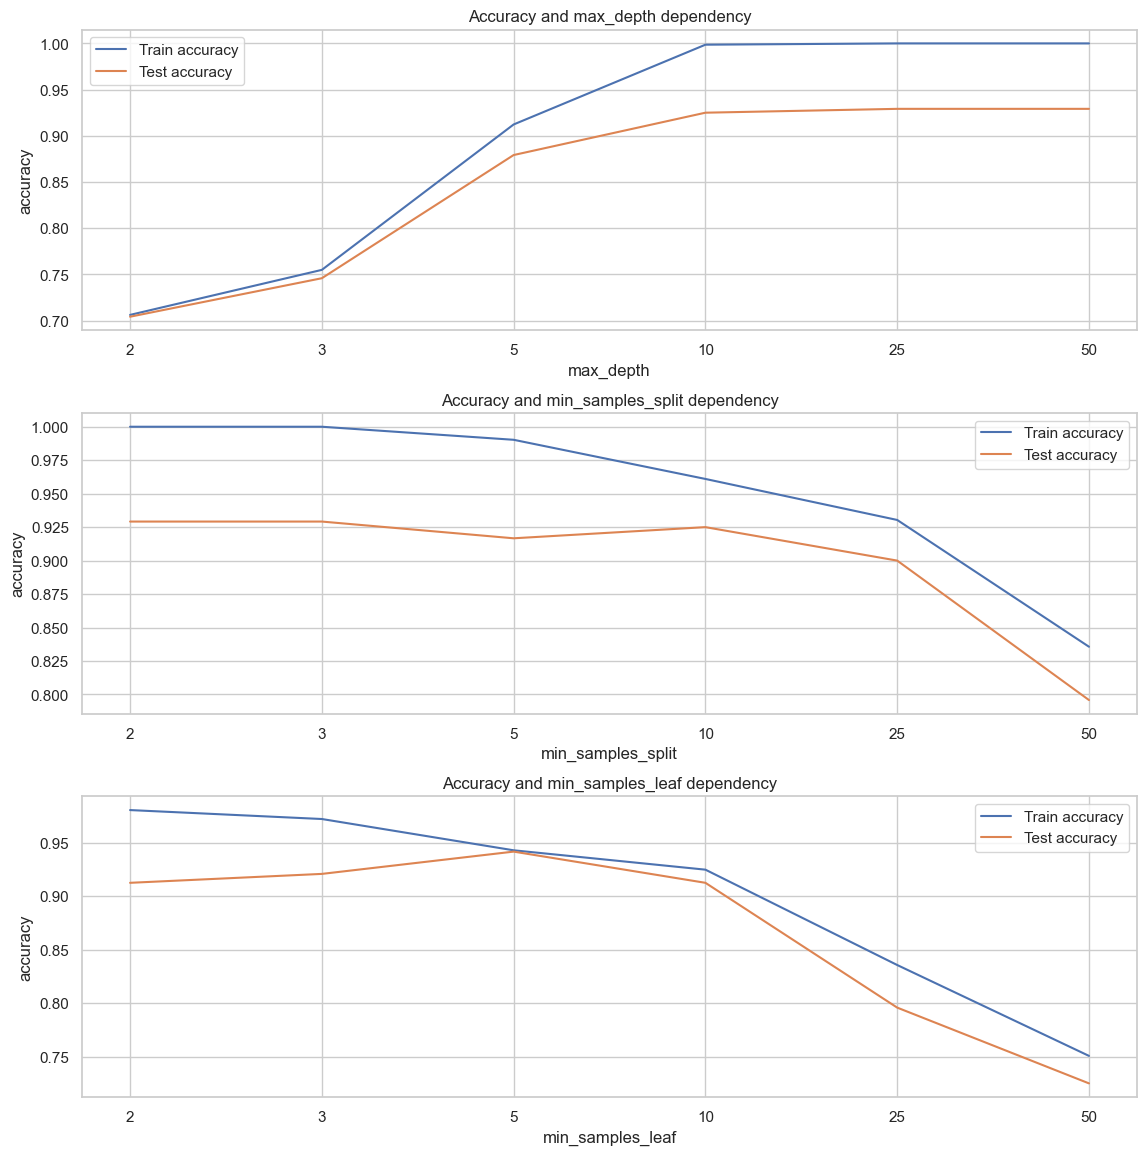

In [21]:
max_depth_arr = [2, 3, 5, 10, 25, 50]
min_samples_leaf_arr = [2, 3, 5, 10, 25, 50]
min_samples_split_arr = [2, 3, 5, 10, 25, 50]

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
plt.tight_layout(pad=3)

train_acc_depth = []
test_acc_depth = []
for max_depth in max_depth_arr:
    clf = MyDecisionTree(["categorical"] * 9, max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_acc_depth.append(accuracy(X_train, y_train, clf))
    test_acc_depth.append(accuracy(X_test, y_test, clf))

ax[0].plot(train_acc_depth, label="Train accuracy")
ax[0].plot(test_acc_depth, label="Test accuracy")
ax[0].set_title("Accuracy and max_depth dependency")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("accuracy")
ax[0].set_xticks(ticks=list(range(6)), labels=max_depth_arr)
ax[0].legend(loc='best')

train_acc_split = []
test_acc_split = []
for min_samples_split in min_samples_split_arr:
    clf = MyDecisionTree(["categorical"] * 9, min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    train_acc_split.append(accuracy(X_train, y_train, clf))
    test_acc_split.append(accuracy(X_test, y_test, clf))

ax[1].plot(train_acc_split, label="Train accuracy")
ax[1].plot(test_acc_split, label="Test accuracy")
ax[1].set_title("Accuracy and min_samples_split dependency")
ax[1].set_xlabel("min_samples_split")
ax[1].set_ylabel("accuracy")
ax[1].set_xticks(ticks=list(range(6)), labels=min_samples_split_arr)
ax[1].legend(loc='best')

train_acc_leaf = []
test_acc_leaf = []
for min_samples_leaf in min_samples_leaf_arr:
    clf = MyDecisionTree(["categorical"] * 9, min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    train_acc_leaf.append(accuracy(X_train, y_train, clf))
    test_acc_leaf.append(accuracy(X_test, y_test, clf))

ax[2].plot(train_acc_leaf, label="Train accuracy")
ax[2].plot(test_acc_leaf, label="Test accuracy")
ax[2].set_title("Accuracy and min_samples_leaf dependency")
ax[2].set_xlabel("min_samples_leaf")
ax[2].set_ylabel("accuracy")
ax[2].set_xticks(ticks=list(range(6)), labels=min_samples_leaf_arr)
ax[2].legend(loc='best')

plt.show()

Видим те же зависимости, которые мы отмечали в первой части домашки:

- большой max_depth == лучше точность, но выше риск переобучения
- большой min_samples_split == ниже точность, но модель не выделяет зоны с 1-2 точками
- большой min_samples_leaf == ниже точность, но в листах находятся большие выборки, а значит выше генерализация

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [22]:
cars = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data")
cars.head()
    

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [23]:
cars[["vhigh", "vhigh.1", "2", "2.1", "small", "low"]] = cars[["vhigh", "vhigh.1", "2", "2.1", "small", "low"]].apply(LabelEncoder().fit_transform)
cars["unacc"] = (cars["unacc"].isin(["vgood", "good"])).astype(int)
cars.sample(5)

,vhigh,vhigh.1,2,2.1,small,low,unacc
70,3,3,2,1,0,0,0
947,2,3,3,0,1,1,0
713,0,2,2,1,1,1,0
130,3,0,0,2,1,0,0
96,3,3,3,1,0,2,0


In [24]:
nursery = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data")
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom


In [25]:
np.all(nursery["convenient"] == nursery["convenient.1"])

False

In [26]:
np.all(nursery["recommended"] == nursery["recommend"])

False

Очень странные признаки...

In [27]:
features = ["usual", "proper", "complete", "1", "convenient", "convenient.1", "nonprob", "recommended"]
nursery[features] = nursery[features].apply(LabelEncoder().fit_transform)
nursery["recommend"] = (nursery["recommend"].isin(["very_recom", "priority", "spec_prior"])).astype(int)
nursery.sample(5)

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
1186,2,2,1,1,1,1,1,0,0
3294,2,0,2,1,0,0,0,1,1
569,2,3,3,2,2,1,2,2,1
12789,0,4,2,0,1,1,0,1,1
6037,1,2,2,3,1,0,1,0,0


In [28]:
datasets_X = [mushrooms.values[:, 1:], tic_tac_toe.values[:, :-1], cars.values[:, :-1], nursery.values[:, :-1]]
datasets_y = [mushrooms.values[:, 0], tic_tac_toe.values[:, -1], cars.values[:, -1], nursery.values[:, -1]]
datasets_names = ["mushrooms", "tic-tac-toe", "cars", "nursery"]

In [29]:
scores_df = pd.DataFrame(columns=["all_real_acc", "all_cat_acc", "all_real_ohe_acc", "sklearn_tree_acc"])

In [59]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

for X, y, name in tqdm(zip(datasets_X, datasets_y, datasets_names)):
    
    scores = []

    cv_folds = KFold(10, shuffle=True, random_state=42)

    # DecisionTree, считающий все признаки вещественными
    clf = MyDecisionTree(feature_types=["real"] * X.shape[1])
    scores.append(cross_val_score(clf, X, y, scoring=make_scorer(accuracy_score), cv=cv_folds).mean())

    # DecisionTree, считающий все признаки категориальными
    clf = MyDecisionTree(feature_types=["categorical"] * X.shape[1])
    scores.append(cross_val_score(clf, X, y, scoring=make_scorer(accuracy_score), cv=cv_folds).mean())

    # DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
    X_ohe = OneHotEncoder(sparse=False).fit_transform(X.copy())
    clf = MyDecisionTree(feature_types=["real"] * X_ohe.shape[1])
    scores.append(cross_val_score(clf, X_ohe, y, scoring=make_scorer(accuracy_score), cv=cv_folds).mean())

    # DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).
    clf = DecisionTreeClassifier()
    scores.append(cross_val_score(clf, X, y, scoring=make_scorer(accuracy_score), cv=cv_folds).mean())

    scores_df.loc[name] = scores

scores_df

0it [00:00, ?it/s]

4it [00:11,  2.81s/it]


,all_real_acc,all_cat_acc,all_real_ohe_acc,sklearn_tree_acc
mushrooms,1.000000,1.000000,1.000000,1.000000
tic-tac-toe,0.878914,0.945757,0.945757,0.897654
cars,0.990721,0.988987,0.990147,0.991303
nursery,0.999691,0.999691,0.999614,0.999691


In [45]:
len(datasets_X[1])

958

In [58]:
X, y = datasets_X[1], datasets_y[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

clf = MyDecisionTree(feature_types=["categorical"] * X.shape[1])
clf.fit(X_train, y_train)

print(f"Train score: {accuracy(X_train, y_train, clf):.2f}")
print(f"Test score: {accuracy(X_test, y_test, clf):.2f}")

Train score: 1.00
Test score: 0.22


Фан-факт: Данные тик-така как-то отсорчены (как минимум таргет сначала весь 1, а потом весь 0), поэтому если не делать шаффл, то получается как выше. Вот почему данные надо проверять...

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Про mushrooms даже говорить не будем - датасет, кажется, слишком простой для достаточно глубокого дерева. nursery тоже одинаково хорош и почти везде имеет 1 accuracy.

У cars почти незаметная просадка в случае категориальных фичей. Сильнее всего результаты отличаются в датасете tic-tac-toe - численные фичи показали себя значительно хуже.

С одной стороны, категориальные фичи в датасете мы тоже как-то переводим в числа, но есть большое но: мы ищем лучшее разбиение среди всех возможных подмножеств этого признака. В сулчае, когда мы сначала делаем LabelEncoder (который никак не упорядочивает значения классов), а потом запускаем дерево - лучший сплит ищется не по подмножествам значения признака а по разбиению действительной прямой. Скорее всего в tic-tac-toe размеры значений в каждой из фичей не одинаковые, отчего категиориальные фичи лучше.

По этой же причине ohe дает сравнимый результат - в этом случае мы даем модели полную свободу делить фичи: дерево на самом деле может выучить любое разбиение категориального признака на подмножества. 

Компонента случайности присутсвует, если не фиксировать random_state - как уже говорилось, даже небольшое изменение в выборке сильно влияет на структуру дерева. Повлиять можно ансамблями :)

Если делать стратифицированное разбиение датасета (по таргету, а еще лучше по признакам тоже), то дерево тоже будет менее случайным

In [72]:
from collections import Counter

print("Количество объектов по значению признака в tic-tac-toe")
print(Counter(datasets_X[1][:, 0]))
print()
print("Количество объектов по значению признака в cars")
print(Counter(datasets_X[2][:, 0]))
print()
print("Количество объектов по значению признака в nursery")
print(Counter(datasets_X[3][:, 0]))

Количество объектов по значению признака в tic-tac-toe
Counter({2: 418, 1: 335, 0: 205})

Количество объектов по значению признака в cars
Counter({0: 432, 2: 432, 1: 432, 3: 431})

Количество объектов по значению признака в nursery
Counter({1: 4320, 0: 4320, 2: 4319})


Я пробежался по рандомным признакам - в nursery и cars они все равны по количеству уникальных, а в крестиках-ноликах - увы, нет. Можно было бы построить графики, но я не успеваю, извинияюсь(

Вставьте что угодно, описывающее ваши впечатления от этого задания:

эх, вставил бы, но надо бежать другие дедлайны закрывать(((